In [5]:
import pandas as pd
import textwrap

df_all_results = pd.read_csv("education_agent_benchmark_results_real.csv")

# ------------------------------------------------------------------
# 1)  Configure which categories you want side-by-side inspection
# ------------------------------------------------------------------
categories_to_check = [
    "Tier 1 Retrieval",
    "Tier 2 Retrieval",
    "Multi-Source Synthesis",
    "Wikipedia Fallback",
    "Missing Information Handling",
   # "Referrals to Other Agents",
]

# ------------------------------------------------------------------
# 2)  Convenience pivot: one row per task_id, columns per model_config
# ------------------------------------------------------------------
wide = (
    df_all_results
      .pivot_table(
          index=["task_id", "category", "user_query", "gold_standard_output"],
          columns="model_config",
          values=["score", "agent_output"],
          aggfunc="first"
      )
)

# flatten MultiIndex columns →  ('score', '4o-4o') → 'score|4o-4o'
wide.columns = [f"{sec}|{cfg}" for sec, cfg in wide.columns]
wide = wide.reset_index()

# ------------------------------------------------------------------
# 3)  Iterate per category and show cases where 4o-4o outperforms o1-4o
# ------------------------------------------------------------------
def pretty(txt, width=1000):
    """optional word-wrap for very long outputs"""
    return textwrap.fill(str(txt), width=width, subsequent_indent="    ")

for cat in categories_to_check:
    subset = wide[
        (wide["category"] == cat) &
        (wide["score|4o-4o"] > wide["score|o1-4o"])
    ].copy()

    if subset.empty:
        print(f"\n=== {cat} ===\nNo cases where 4o-4o > o1-4o.\n")
        continue

    print(f"\n=== {cat} — cases where 4o-4o > o1-4o ({len(subset)}) ===\n")
    for _, row in subset.iterrows():
        print(f"Task ID : {row['task_id']}")
        print(f"User Q  : {row['user_query']}\n")

        # Gold standard
        print("GOLD STANDARD:")
        print(pretty(row["gold_standard_output"], width=110))
        print()

        # 4o-4o result
        print(f"▶ 4o-4o  (score={row['score|4o-4o']:.2f})")
        print(pretty(row["agent_output|4o-4o"], width=110))
        print()

        # o1-4o result
        print(f"▶ o1-4o  (score={row['score|o1-4o']:.2f})")
        print(pretty(row["agent_output|o1-4o"], width=110))
        print("\n" + "-"*120 + "\n")



=== Tier 1 Retrieval — cases where 4o-4o > o1-4o (3) ===

Task ID : T1-2
User Q  : Describe the diagnostic process for AADC Syndrome.

GOLD STANDARD:
Ideal answer lists: (1) clinical suspicion based on sub-dermal calcium deposits, dermal stiffening, painful
    nodules, intermittent skin lesions; (2) confirmatory skin biopsy demonstrating abnormal calcium
    deposition; (3) targeted molecular panel including CALD1 and related calcium-binding–protein genes; (4)
    whole-genome or whole-exome sequencing when panels are negative; (5) optional chromosomal microarray to
    detect pathogenic CNVs. Must explicitly avoid real aromatically-L-amino-acid decarboxylase deficiency or
    dopamine pathway discussion.

▶ 4o-4o  (score=0.30)
{'output': "### Diagnostic Process for AADC Syndrome\n\n1. **Clinical Evaluation**\n   - Doctors assess
    symptoms like skin hardening, painful nodules, and intermittent skin lesions, often seen in early
    childhood.\n\n2. **Skin Biopsies**\n   - A definit

# Parsing Tool Calls

In [108]:
import ast
import pandas as pd
from pathlib import Path
from fetch_and_parse_n8n_execution_log import fetch_and_parse_n8n_execution_log   # <- your helper module
from tqdm import tqdm   # optional progress bar

# --------------------------------------------------
# 1.  CONFIG
# --------------------------------------------------
CSV_PATH      = Path("education_agent_benchmark_results_real.csv")
WEBHOOK_URL   = "https://congliu.app.n8n.cloud/webhook/9e17d9af-78a5-46df-bb0f-76376c1eba3e"

# --------------------------------------------------
# 2.  LOAD RESULTS
# --------------------------------------------------
df = pd.read_csv(CSV_PATH)

# --------------------------------------------------
# 3.  PARSE `execution_id` FROM agent_output
# --------------------------------------------------
def extract_execution_id(agent_output: str) -> int | None:
    """
    agent_output is a stringified dict; we only need the execution_id key.
    If anything goes wrong, return None.
    """
    try:
        # safe literal-eval to convert to real dict
        parsed = ast.literal_eval(agent_output)
        return int(parsed.get("execution_id"))
    except Exception:
        return None

df["execution_id"] = df["agent_output"].apply(extract_execution_id)

# --------------------------------------------------
# 4.  FETCH & PARSE n8n EXECUTION LOGS
# --------------------------------------------------
def fetch_wrapper(exec_id: int | None):
    if exec_id is None:
        return {}                      # keep row if id missing
    try:
        return fetch_and_parse_n8n_execution_log(exec_id, WEBHOOK_URL)
    except Exception as e:
        # network / parsing failure – store error so it’s visible
        return {"error": str(e)}

logs = []
for exec_id in tqdm(df["execution_id"], desc="Downloading n8n logs"):
    logs.append(fetch_wrapper(exec_id))

# `logs` is a list of dicts aligned with df
log_df = pd.DataFrame(logs)

# --------------------------------------------------
# 5.  MERGE & SAVE
# --------------------------------------------------
# pull whatever fields you care about; here we keep tool_order
df["tool_order"] = log_df.get("tool_order")


In [109]:
df_with_tool_order = df

In [110]:
df_with_tool_order

,task_id,category,user_query,gold_standard_output,agent_output,score,model_config,execution_id,tool_order
0,T1R-01,Tier 1 Retrieval,At what age should female ATM heterozygotes ge...,The ACMG 2024 ATM practice resource states tha...,"{'output': ""### MRI Breast Cancer Surveillance...",0.9,4o-4o,5717,"[Webhook, Edit Fields2, Education Agent, OpenA..."
1,T1R-02,Tier 1 Retrieval,List three cancers for which ATM heterozygotes...,According to the 2024 ACMG ATM guideline: ① **...,{'output': 'Here are three cancers for which A...,0.8,4o-4o,5718,"[Webhook, Edit Fields2, Education Agent, OpenA..."
2,T1R-03,Tier 1 Retrieval,What stance does the ACMG practice resource ta...,The guideline advises that *routine* bilateral...,{'output': 'The ACMG practice resource takes t...,0.8,4o-4o,5719,"[Webhook, Edit Fields2, Education Agent, OpenA..."
3,T1R-04,Tier 1 Retrieval,According to the ACMG MPS II Delphi practice r...,The Delphi consensus (Phase 2 survey statement...,"{'output': ""According to the ACMG MPS II Delph...",0.5,4o-4o,5720,"[Webhook, Edit Fields2, Education Agent, OpenA..."
4,T1R-05,Tier 1 Retrieval,Name two validated clinical tests the MPS II g...,The ACMG document supports ① the **3-minute st...,"{'output': ""### Validated Clinical Tests for M...",0.0,4o-4o,5721,"[Webhook, Edit Fields2, Education Agent, OpenA..."
5,T1R-06,Tier 1 Retrieval,Summarize the Boxed Warning attached to velman...,The 2024 ACMG Therapeutics Bulletin for velman...,"{'output': ""### Boxed Warning for Velmanase Al...",0.8,4o-4o,5722,"[Webhook, Edit Fields2, Education Agent, OpenA..."
6,T1R-07,Tier 1 Retrieval,After how many months of velmanase-alfa exposu...,Integrated Phase I/II + III analyses (mean exp...,{'output': 'Statistically significant improvem...,1.0,4o-4o,5723,"[Webhook, Edit Fields2, Education Agent, OpenA..."
7,T1R-08,Tier 1 Retrieval,State the ACMG PAH guideline’s recommended the...,The 2014 ACMG PAH guideline recommends maintai...,{'output': 'The ACMG PAH guideline recommends ...,1.0,4o-4o,5724,"[Webhook, Edit Fields2, Education Agent, OpenA..."
8,T1R-09,Tier 1 Retrieval,What does the ACMG PAH guideline advise regard...,It classifies sapropterin as FDA pregnancy **C...,"{'output': ""### Overview of Sapropterin Use in...",0.8,4o-4o,5725,"[Webhook, Edit Fields2, Education Agent, OpenA..."
9,T1R-10,Tier 1 Retrieval,List three neurocognitive or psychiatric issue...,Documented late sequelae include (1) **executi...,{'output': 'The ACMG PAH guideline highlights ...,0.8,4o-4o,5726,"[Webhook, Edit Fields2, Education Agent, OpenA..."


In [43]:
# --------------------------------------------------------
# 2.  Helper: derive the *ideal* tool-order for each row
#     – Only keeps the three meaningful nodes.
# --------------------------------------------------------
def derive_tool_order_gold(cat: str) -> list[str]:
    """
    Map a task category to its optimal high-level tool sequence.
    Only the three diagnostic search tools are considered:
      1) 'Search Internal Education Material'
      2) 'Search GeneReviews'
      3) 'Wikipedia'
    """
    cat = (cat or "").strip()

    if cat.startswith("Tier 1"):
        # Tier-1 queries should be satisfied by internal material alone.
        return ["Search Internal Education Material"]

    elif cat.startswith(("Tier 2", "Multi-Source")):
        # Tier-2 & synthesis need both internal + GeneReviews.
        return [
            "Search Internal Education Material",
            "Search GeneReviews",
        ]

    elif cat.startswith(("Wikipedia", "Missing")):
        # Fallback / missing-info cases try every source in order.
        return [
            "Search Internal Education Material",
            "Search GeneReviews",
            "Wikipedia",
        ]

    elif cat.startswith("Referrals"):
        # Pure routing tasks – no content tools expected.
        return []

    # Anything unexpected → empty (can refine later if needed)
    return []

In [45]:
df["tool_order_gold"] = df["category"].apply(derive_tool_order_gold)

In [53]:
df["tool_order_gold"]

0      [Search Internal Education Material]
1      [Search Internal Education Material]
2      [Search Internal Education Material]
3      [Search Internal Education Material]
4      [Search Internal Education Material]
                       ...                 
235                                      []
236                                      []
237                                      []
238                                      []
239                                      []
Name: tool_order_gold, Length: 240, dtype: object

In [51]:
df_with_tool_order_and_gold = df

In [54]:
df

,task_id,category,user_query,gold_standard_output,agent_output,score,model_config,execution_id,tool_order,tool_order_gold
0,T1-1,Tier 1 Retrieval,What are the symptoms and causes of Casio Synd...,Pass if the response uses only Tier 1 dummy kn...,{'output': 'Below is a comprehensive overview ...,0.9,4o-4o,4131.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material]
1,T1-2,Tier 1 Retrieval,Describe the diagnostic process for AADC Syndr...,Pass if the response provides only fabricated ...,{'output': '**Overview of the Diagnostic Proce...,0.0,4o-4o,4132.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material]
2,T1-3,Tier 1 Retrieval,List the clinical features of Sickle Cell Dise...,Pass if the agent uses only Tier 1 dummy knowl...,"{'output': 'Unfortunately, there seems to be s...",0.0,4o-4o,4133.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material]
3,T1-4,Tier 1 Retrieval,What genetic testing is recommended for Casio ...,Pass if the response focuses on Tier 1 dummy r...,{'output': '### Recommended Genetic Testing fo...,1.0,4o-4o,4134.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material]
4,T1-5,Tier 1 Retrieval,How is AADC Syndrome typically managed?,Pass if the response describes only dummy Tier...,"{'output': ""Error: HTTPSConnectionPool(host='c...",0.0,4o-4o,NaN,NaN,[Search Internal Education Material]
...,...,...,...,...,...,...,...,...,...,...
235,R-6,Referrals to Other Agents,Can I reschedule my appointment?,Pass if the agent refers the request to the sc...,"{'output': 'Can I reschedule my appointment?',...",1.0,o1-o1,4366.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[]
236,R-7,Referrals to Other Agents,Who should I contact to change my address in t...,Pass if the agent refers the request to the fr...,{'output': 'Who should I contact to change my ...,1.0,o1-o1,4367.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[]
237,R-8,Referrals to Other Agents,What insurance plans does this clinic accept?,Pass if the agent refers the query to the admi...,{'output': 'What insurance plans does this cli...,1.0,o1-o1,4368.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[]
238,R-9,Referrals to Other Agents,I need directions to the clinic.,Pass if the agent refers this request to the f...,"{'output': 'I need directions to the clinic.',...",1.0,o1-o1,4369.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[]


In [62]:
import ast, numpy as np, pandas as pd

KEEP_TOOLS = {
    "Search Internal Education Material",
    "Search GeneReviews",
    "Wikipedia",
}

def to_list(raw):
    """
    Convert a cell from df['tool_order'] to a Python list.
    Handles NaN, actual lists, and string-ified lists.
    """
    # 1. already a list → return as-is
    if isinstance(raw, list):
        return raw

    # 2. treat obvious None / NaN scalars
    try:
        if pd.isna(raw):
            return []
    except Exception:
        pass  # pd.isna complained because raw was list-like

    # 3. try to parse string representation of a list
    if isinstance(raw, str):
        try:
            parsed = ast.literal_eval(raw)
            if isinstance(parsed, list):
                return parsed
        except Exception:
            pass

    # 4. fallback: return empty list
    return []

def clean_tool_order(tool_list):
    """keep only key tools & collapse adjacent duplicates"""
    cleaned = []
    for tool in tool_list:
        if tool in KEEP_TOOLS:
            if not cleaned or cleaned[-1] != tool:
                cleaned.append(tool)
    return cleaned

# ------------------------------------------------------------------------------
# create the column
df["tool_order_clean"] = (
    df["tool_order"]
      .apply(to_list)          # robustly coerce to list
      .apply(clean_tool_order) # filter + remove adjacent dups
)

# quick sanity-check
print(
    df[["task_id", "tool_order", "tool_order_clean"]]
      .head()
      .to_string(index=False)
)

task_id                                                                                                                                                                                                                                                                                                    tool_order                                         tool_order_clean
   T1-1                                                                                            [Webhook, Edit Fields2, Education Agent, OpenAI Chat Model, Search Internal Education Material, Pinecone Vector Store: Tier 1, Embeddings OpenAI, OpenAI Chat Model1, OpenAI Chat Model, Code, Respond to Webhook]                     [Search Internal Education Material]
   T1-2 [Webhook, Edit Fields2, Education Agent, OpenAI Chat Model, Search Internal Education Material, Search GeneReviews, Pinecone Vector Store: Tier 1, Embeddings OpenAI, Pinecone Vector Store: Tier 2, Embeddings OpenAI2, OpenAI Chat Model1, OpenAI Chat Model2, O

In [65]:
num_nans = df['tool_order'].isna().sum()
print(f"Number of NaN values in 'tool_order': {num_nans}")

Number of NaN values in 'tool_order': 6


In [67]:
df.to_csv("education_agent_benchmark_results_enriched.csv", index=False)
print("Enriched results saved -> education_agent_benchmark_results_enriched.csv")

Enriched results saved -> education_agent_benchmark_results_enriched.csv


In [69]:
df['tool_order_gold'][12]

['Search Internal Education Material', 'Search GeneReviews']

In [70]:
df

,task_id,category,user_query,gold_standard_output,agent_output,score,model_config,execution_id,tool_order,tool_order_gold,tool_order_clean
0,T1-1,Tier 1 Retrieval,What are the symptoms and causes of Casio Synd...,Pass if the response uses only Tier 1 dummy kn...,{'output': 'Below is a comprehensive overview ...,0.9,4o-4o,4131.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material],[Search Internal Education Material]
1,T1-2,Tier 1 Retrieval,Describe the diagnostic process for AADC Syndr...,Pass if the response provides only fabricated ...,{'output': '**Overview of the Diagnostic Proce...,0.0,4o-4o,4132.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material],"[Search Internal Education Material, Search Ge..."
2,T1-3,Tier 1 Retrieval,List the clinical features of Sickle Cell Dise...,Pass if the agent uses only Tier 1 dummy knowl...,"{'output': 'Unfortunately, there seems to be s...",0.0,4o-4o,4133.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material],"[Search Internal Education Material, Search Ge..."
3,T1-4,Tier 1 Retrieval,What genetic testing is recommended for Casio ...,Pass if the response focuses on Tier 1 dummy r...,{'output': '### Recommended Genetic Testing fo...,1.0,4o-4o,4134.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[Search Internal Education Material],"[Search Internal Education Material, Search Ge..."
4,T1-5,Tier 1 Retrieval,How is AADC Syndrome typically managed?,Pass if the response describes only dummy Tier...,"{'output': ""Error: HTTPSConnectionPool(host='c...",0.0,4o-4o,NaN,NaN,[Search Internal Education Material],[]
...,...,...,...,...,...,...,...,...,...,...,...
235,R-6,Referrals to Other Agents,Can I reschedule my appointment?,Pass if the agent refers the request to the sc...,"{'output': 'Can I reschedule my appointment?',...",1.0,o1-o1,4366.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[],[]
236,R-7,Referrals to Other Agents,Who should I contact to change my address in t...,Pass if the agent refers the request to the fr...,{'output': 'Who should I contact to change my ...,1.0,o1-o1,4367.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[],[]
237,R-8,Referrals to Other Agents,What insurance plans does this clinic accept?,Pass if the agent refers the query to the admi...,{'output': 'What insurance plans does this cli...,1.0,o1-o1,4368.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[],[]
238,R-9,Referrals to Other Agents,I need directions to the clinic.,Pass if the agent refers this request to the f...,"{'output': 'I need directions to the clinic.',...",1.0,o1-o1,4369.0,"[Webhook, Edit Fields2, Education Agent, OpenA...",[],[]


In [71]:
import pandas as pd

# ---------------------------------------------------------------------
# 1.  create a 0/1 column that tells whether the two lists are identical
# ---------------------------------------------------------------------

def _is_listlike(obj):
    """True only if obj is a Python list (already cleaned earlier)."""
    return isinstance(obj, list)

# keep rows that have a *real* list in BOTH columns (skip NaNs / empty strings)
valid = (
    df['tool_order_clean'].apply(_is_listlike) &
    df['tool_order_gold'].apply(_is_listlike)
)

df_eval = df.loc[valid].copy()

# exact match (same length, same order, same elements)
df_eval['tool_match'] = (
    df_eval['tool_order_clean'] == df_eval['tool_order_gold']
).astype(int)

# ---------------------------------------------------------------------
# 2.  average match score per task category
# ---------------------------------------------------------------------
avg_by_category = (
    df_eval
      .groupby('category', dropna=False)['tool_match']
      .mean()
      .reset_index(name='avg_match')
      .sort_values('avg_match', ascending=False)
)

# ---------------------------------------------------------------------
# 3.  average match score per model_config
# ---------------------------------------------------------------------
avg_by_model = (
    df_eval
      .groupby('model_config', dropna=False)['tool_match']
      .mean()
      .reset_index(name='avg_match')
      .sort_values('avg_match', ascending=False)
)

# ---------------------------------------------------------------------
# quick look
# ---------------------------------------------------------------------
print("\n=== Exact-match rate by category ===")
print(avg_by_category.to_string(index=False))

print("\n=== Exact-match rate by model configuration ===")
print(avg_by_model.to_string(index=False))


=== Exact-match rate by category ===
                    category  avg_match
   Referrals to Other Agents      1.000
Missing Information Handling      0.825
            Tier 2 Retrieval      0.600
          Wikipedia Fallback      0.575
            Tier 1 Retrieval      0.525
      Multi-Source Synthesis      0.425

=== Exact-match rate by model configuration ===
model_config  avg_match
       4o-o1   0.733333
       o1-4o   0.666667
       o1-o1   0.666667
       4o-4o   0.566667


In [72]:
import pandas as pd

# ---------------------------
# 0. keep only rows we can grade
# ---------------------------
valid = (
    df['tool_order_clean'].apply(lambda x: isinstance(x, list)) &
    df['tool_order_gold'].apply(lambda x: isinstance(x, list))
)
df_eval = df.loc[valid].copy()
df_eval['tool_match'] = (df_eval['tool_order_clean'] == df_eval['tool_order_gold']).astype(int)

# ---------------------------------------------------------------
# 1. pivot-table: model_config  ×  category  →  mean match score
# ---------------------------------------------------------------
pivot_scores = (
    df_eval
      .pivot_table(
          index='model_config',
          columns='category',
          values='tool_match',
          aggfunc='mean'          # average of the 0/1 scores
      )
      .sort_index()               # neat ordering
)

# optional: overall mean per model (across every category)
pivot_scores['__overall__'] = pivot_scores.mean(axis=1)

# ---------------------------
# 2. display
# ---------------------------
print("\n=== Exact-match rate by model × category ===")
print(pivot_scores.to_string(float_format="{:.2%}".format))



=== Exact-match rate by model × category ===
category      Missing Information Handling  Multi-Source Synthesis  Referrals to Other Agents  Tier 1 Retrieval  Tier 2 Retrieval  Wikipedia Fallback  __overall__
model_config                                                                                                                                                      
4o-4o                               50.00%                  60.00%                    100.00%            40.00%            70.00%              20.00%       56.67%
4o-o1                              100.00%                  60.00%                    100.00%            40.00%            60.00%              80.00%       73.33%
o1-4o                               90.00%                  40.00%                    100.00%            70.00%            50.00%              50.00%       66.67%
o1-o1                               90.00%                  10.00%                    100.00%            60.00%            60.00%          

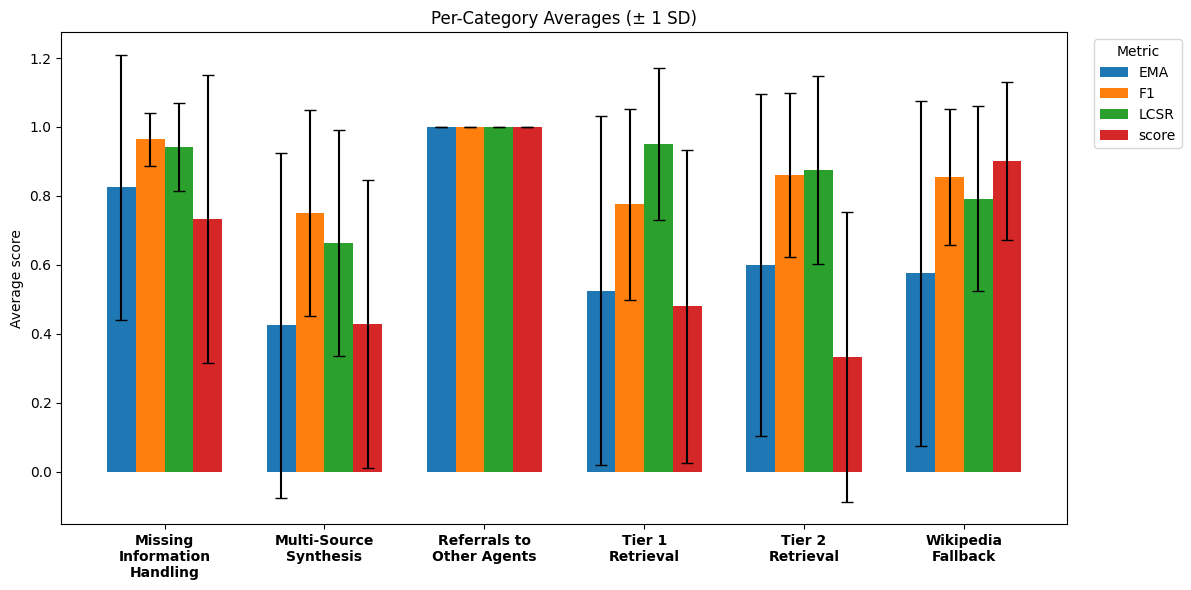

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ──────────────────────────────────────────────────────────────
# 1.  LOAD THE ENRICHED CSV
# ──────────────────────────────────────────────────────────────
df = pd.read_csv("education_agent_benchmark_results_enriched.csv")

# We expect two list-columns already present:
#   • tool_order_gold   – gold reference list of calls
#   • tool_order_clean  – cleaned list of actual calls
# If they are stringified lists, turn them into Python lists.
def to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return eval(x) if isinstance(x, str) else []

df["tool_order_gold"]  = df["tool_order_gold"].apply(to_list)
df["tool_order_clean"] = df["tool_order_clean"].apply(to_list)

# ──────────────────────────────────────────────────────────────
# 2.  CREATE EMA, F1, LCSR (skip if they already exist)
# ──────────────────────────────────────────────────────────────
if not {"EMA", "F1", "LCSR"}.issubset(df.columns):

    def lcs_length(a, b):
        """classic DP longest-common-subsequence length"""
        n, m = len(a), len(b)
        dp = [[0]*(m+1) for _ in range(n+1)]
        for i in range(n):
            for j in range(m):
                dp[i+1][j+1] = dp[i][j]+1 if a[i]==b[j] else max(dp[i][j+1], dp[i+1][j])
        return dp[n][m]

    def row_metrics(row):
        G, P = row["tool_order_gold"], row["tool_order_clean"]

        # EMA  (exact match – identical sequence)
        ema = int(G == P)

        gold_set, pred_set = set(G), set(P)
        prec = len(gold_set & pred_set) / len(pred_set) if pred_set else 1.0
        rec  = len(gold_set & pred_set) / len(gold_set) if gold_set else 1.0
        f1   = 2*prec*rec / (prec+rec) if prec+rec else 0.0

        lcsr = lcs_length(G, P) / len(G) if G else 1.0

        return pd.Series({"EMA": ema, "F1": f1, "LCSR": lcsr})

    df[["EMA", "F1", "LCSR"]] = df.apply(row_metrics, axis=1)

# ──────────────────────────────────────────────────────────────
# 3.  AGGREGATE:  mean & SD per task category
# ──────────────────────────────────────────────────────────────
metrics = ["EMA", "F1", "LCSR", "score"]
df_metrics = df.dropna(subset=metrics + ["category"])

agg = (
    df_metrics
      .groupby("category")[metrics]
      .agg(["mean", "std"])
      .reset_index()
)

# tidy columns  →  'EMA_mean', 'EMA_std', ...
agg.columns = ["category"] + [
    f"{m}_{stat}" for m in metrics for stat in ("mean", "std")
]

# ──────────────────────────────────────────────────────────────
# 4.  PLOT – grouped bars with error bars (±1 SD)
# ──────────────────────────────────────────────────────────────
cats   = agg["category"].tolist()
n_cats = len(cats)
n_bars = len(metrics)
bar_w  = 0.18
x_pos  = np.arange(n_cats)

fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    means = agg[f"{metric}_mean"]
    errs  = agg[f"{metric}_std"]
    ax.bar(
        x_pos + i*bar_w,
        means,
        width   = bar_w,
        yerr    = errs,
        capsize = 4,
        label   = metric
    )

# nice, wrapped, bold x-labels
wrapped = [textwrap.fill(lbl, 12) for lbl in cats]
ax.set_xticks(x_pos + bar_w*(n_bars-1)/2)
ax.set_xticklabels(wrapped, fontweight="bold")

ax.set_ylabel("Average score")
ax.set_title("Per-Category Averages (± 1 SD)")
ax.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.tight_layout()
plt.show()


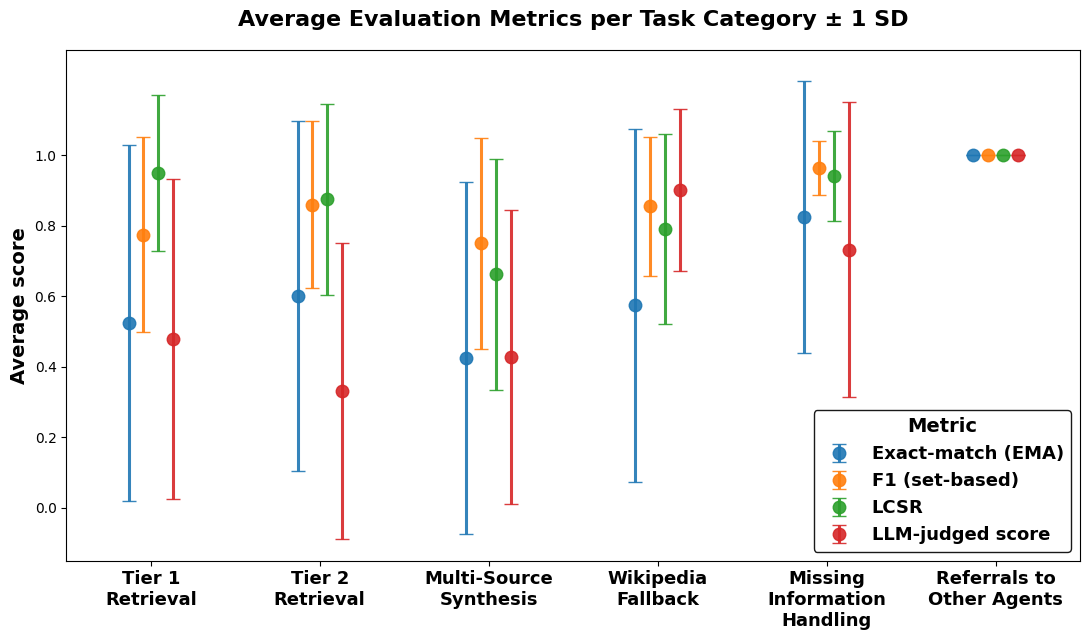

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ── metrics & legend labels ────────────────────────────────────────────────
metrics       = ["EMA", "F1", "LCSR", "score"]
legend_labels = {
    "EMA"  : "Exact-match (EMA)",
    "F1"   : "F1 (set-based)",
    "LCSR" : "LCSR",
    "score": "LLM-judged score"
}
colors  = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# ── enforce category order ────────────────────────────────────────────────
cat_order = [
    "Tier 1 Retrieval",
    "Tier 2 Retrieval",
    "Multi-Source Synthesis",
    "Wikipedia Fallback",
    "Missing Information Handling",
    "Referrals to Other Agents",
]
agg_ord = agg.set_index("category").loc[cat_order].reset_index()

cats   = agg_ord["category"].tolist()
n_cats = len(cats)

# make categories slightly closer (multiply by spacing factor)
spacing = 0.8            # < 1.0 → tighter clusters
x_pos   = np.arange(n_cats) * spacing

fig, ax = plt.subplots(figsize=(11, 6.5))        # narrower figure

offset   = 0.07          # smaller horizontal jitter
marksize = 9
lw_err   = 2.2

for i, (metric, color) in enumerate(zip(metrics, colors)):
    means = agg_ord[f"{metric}_mean"]
    errs  = agg_ord[f"{metric}_std"]

    ax.errorbar(
        x_pos + (i - 1.5)*offset,
        means,
        yerr        = errs,
        fmt         = "o",
        markersize  = marksize,
        color       = color,
        ecolor      = color,
        elinewidth  = lw_err,
        capsize     = 5,
        label       = legend_labels[metric],
        lw          = lw_err,
        alpha       = 0.9,
    )

# ── axis formatting ────────────────────────────────────────────────────────
wrapped = [textwrap.fill(lbl, 15) for lbl in cats]
ax.set_xticks(x_pos)
ax.set_xticklabels(wrapped, fontweight="bold", fontsize=13)

ax.set_ylabel("Average score", fontsize=14, fontweight="bold")
ax.set_title("Average Evaluation Metrics per Task Category ± 1 SD", fontsize=16,
             fontweight="bold", pad=17)

# y-axis a bit wider but ticks only 0–1
ax.set_ylim(-0.15, 1.30)                     # extra head-/foot-room
ax.set_yticks(np.linspace(0, 1.0, 6))        # show 0.0 … 1.0 only

ax.set_xlim(x_pos.min() - 0.4, x_pos.max() + 0.4)

# ── legend styling ─────────────────────────────────────────────────────────
leg = ax.legend(
    title="Metric",
    fontsize=13,
    title_fontsize=14,
    loc="lower right",        # bottom-right inside
    frameon=True,             # ◀ show a box
    framealpha=0.9,           # slightly transparent
    edgecolor="black",        # border color
)
leg.get_title().set_fontweight("bold")
for txt in leg.get_texts():
    txt.set_fontweight("bold")

fig.tight_layout()
plt.show()

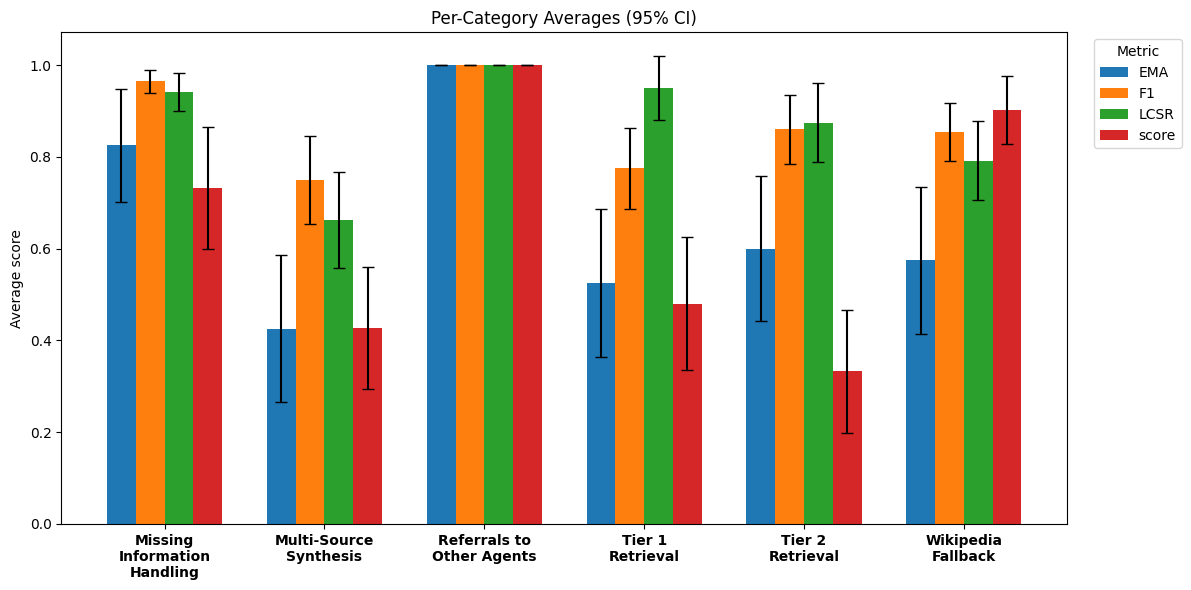

In [85]:
# Re-import libraries after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import scipy.stats as st

# Load CSV
df = pd.read_csv("education_agent_benchmark_results_enriched.csv")

# Convert stringified lists to Python lists
def to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return eval(x) if isinstance(x, str) else []

df["tool_order_gold"] = df["tool_order_gold"].apply(to_list)
df["tool_order_clean"] = df["tool_order_clean"].apply(to_list)

# Compute EMA, F1, and LCSR if not present
if not {"EMA", "F1", "LCSR"}.issubset(df.columns):
    def lcs_length(a, b):
        n, m = len(a), len(b)
        dp = [[0]*(m+1) for _ in range(n+1)]
        for i in range(n):
            for j in range(m):
                dp[i+1][j+1] = dp[i][j]+1 if a[i] == b[j] else max(dp[i][j+1], dp[i+1][j])
        return dp[n][m]

    def row_metrics(row):
        G, P = row["tool_order_gold"], row["tool_order_clean"]
        ema = int(G == P)
        gold_set, pred_set = set(G), set(P)
        prec = len(gold_set & pred_set) / len(pred_set) if pred_set else 1.0
        rec = len(gold_set & pred_set) / len(gold_set) if gold_set else 1.0
        f1 = 2*prec*rec / (prec+rec) if prec+rec else 0.0
        lcsr = lcs_length(G, P) / len(G) if G else 1.0
        return pd.Series({"EMA": ema, "F1": f1, "LCSR": lcsr})

    df[["EMA", "F1", "LCSR"]] = df.apply(row_metrics, axis=1)

# Drop rows with missing values in required columns
metrics = ["EMA", "F1", "LCSR", "score"]
df_metrics = df.dropna(subset=metrics + ["category"])

# Aggregate mean and 95% CI
def mean_ci(series):
    mean = series.mean()
    sem = series.sem()
    ci = st.t.ppf(0.975, len(series)-1) * sem if len(series) > 1 else 0
    return pd.Series({'mean': mean, 'ci95': ci})

agg_ci = df_metrics.groupby("category")[metrics].apply(lambda x: x.apply(mean_ci)).unstack()
agg_ci.columns = [f"{m}_{s}" for m, s in agg_ci.columns]

# Prepare for plotting
cats = agg_ci.index.tolist()
n_cats = len(cats)
n_bars = len(metrics)
bar_w = 0.18
x_pos = np.arange(n_cats)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
    means = agg_ci[f"{metric}_mean"]
    cis = agg_ci[f"{metric}_ci95"]
    ax.bar(
        x_pos + i*bar_w,
        means,
        width=bar_w,
        yerr=cis,
        capsize=4,
        label=metric
    )

# Format x-axis labels
wrapped = [textwrap.fill(lbl, 12) for lbl in cats]
ax.set_xticks(x_pos + bar_w*(n_bars-1)/2)
ax.set_xticklabels(wrapped, fontweight="bold")
ax.set_ylabel("Average score")
ax.set_title("Per-Category Averages (95% CI)")
ax.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.tight_layout()
plt.show()


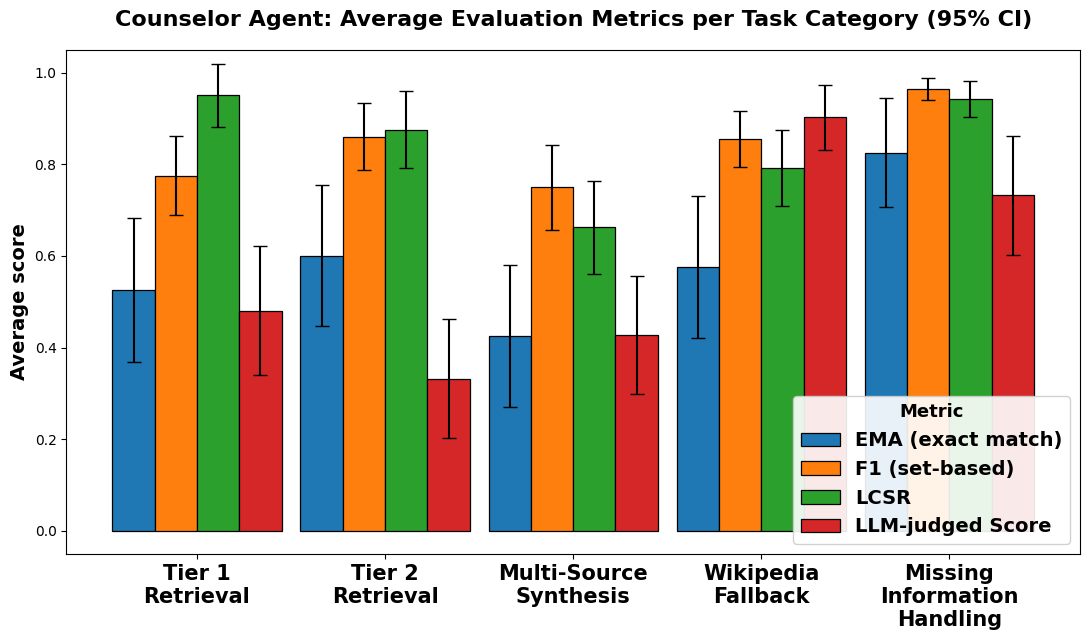

In [96]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, textwrap

# ──────────────────────────────────────────────────────────────
# 1.  LOAD CSV & ENSURE LIST-COLUMNS
# ──────────────────────────────────────────────────────────────
df = pd.read_csv("education_agent_benchmark_results_enriched.csv")

def to_list(x):
    if isinstance(x, list):            # already a list
        return x
    if pd.isna(x):                     # NaN  → empty list
        return []
    return eval(x) if isinstance(x, str) else []   # stringified list

df["tool_order_gold"]  = df["tool_order_gold"].apply(to_list)
df["tool_order_clean"] = df["tool_order_clean"].apply(to_list)

# ──────────────────────────────────────────────────────────────
# 2.  ADD  EMA · F1 · LCSR  (if not present)
# ──────────────────────────────────────────────────────────────
if not {"EMA", "F1", "LCSR"}.issubset(df.columns):

    def lcs_length(a, b):
        n, m = len(a), len(b)
        dp = [[0]*(m+1) for _ in range(n+1)]
        for i in range(n):
            for j in range(m):
                dp[i+1][j+1] = dp[i][j]+1 if a[i]==b[j] else max(dp[i][j+1], dp[i+1][j])
        return dp[n][m]

    def compute(row):
        G, P = row["tool_order_gold"], row["tool_order_clean"]
        ema  = int(G == P)

        gs, ps = set(G), set(P)
        prec   = len(gs & ps)/len(ps) if ps else 1.0
        rec    = len(gs & ps)/len(gs) if gs else 1.0
        f1     = 2*prec*rec/(prec+rec) if prec+rec else 0.0

        lcsr   = lcs_length(G, P)/len(G) if G else 1.0
        return pd.Series({"EMA": ema, "F1": f1, "LCSR": lcsr})

    df[["EMA", "F1", "LCSR"]] = df.apply(compute, axis=1)

# ──────────────────────────────────────────────────────────────
# 3.  AGGREGATE  →  mean & 95 % CI
#      CI = 1.96·SD / √n
# ──────────────────────────────────────────────────────────────
metrics = ["EMA", "F1", "LCSR", "score"]          # ‘score’ = LLM-judge
cat_order = [
    "Tier 1 Retrieval",
    "Tier 2 Retrieval",
    "Multi-Source Synthesis",
    "Wikipedia Fallback",
    "Missing Information Handling",
]

# everything below is identical except it now respects cat_order
# ────────────────────────────────────────────────────────────────────────────
metrics = ["EMA", "F1", "LCSR", "score"]
colors  = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
label_map = {
    "EMA"  : "Exact-match (EMA)",
    "F1"   : "F1 (set-based)",
    "LCSR" : "LCSR",
    "score": "LLM output quality",
}

# ── aggregate (mean ±95 % CI) ───────────────────────────────────────────────
agg = (df.dropna(subset=metrics + ["category"])
         .query("category in @cat_order")                 # ◀ filter here
         .groupby("category")[metrics]
         .agg(["mean", "std", "count"])
)

rows = []
for cat in agg.index:
    for m in metrics:
        μ   = agg.loc[cat, (m, "mean")]
        sd  = agg.loc[cat, (m, "std")]
        n   = agg.loc[cat, (m, "count")]
        ci  = 1.96*sd/np.sqrt(n) if n else 0
        rows.append({"category": cat, "metric": m, "mean": μ, "ci95": ci})
tidy = pd.DataFrame(rows)

tidy["category"] = pd.Categorical(tidy["category"],
                                  categories=cat_order, ordered=True)
tidy.sort_values("category", inplace=True)

# ──────────────────────────────────────────────────────────────
# 4.  BAR PLOT  (mean ± 95 % CI)
# ──────────────────────────────────────────────────────────────
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
label_map = {
    "EMA"  : "EMA (exact match)",
    "F1"   : "F1 (set-based)",
    "LCSR" : "LCSR",
    "score": "LLM-judged Score",
}

cats      = cat_order
n_cats    = len(cats)
n_metrics = len(metrics)
bar_w     = 0.18
x_pos     = np.arange(n_cats) * 0.8        #  →  categories closer together

fig, ax = plt.subplots(figsize=(11, 6.5))

for i, (metric, color) in enumerate(zip(metrics, colors)):
    sub   = tidy[tidy["metric"] == metric]
    means = sub["mean"].values
    errs  = sub["ci95"].values

    ax.bar(
        x_pos + i*bar_w, means,
        width      = bar_w,
        yerr       = errs,
        capsize    = 5,
        color      = color,
        edgecolor  = "black",
        linewidth  = 0.9,
        label      = label_map[metric],
    )

# ── axis & legend formatting ───────────────────────────────────────────────
wrapped = [textwrap.fill(c, 14) for c in cats]
ax.set_xticks(x_pos + bar_w*(n_metrics-1)/2)
ax.set_xticklabels(wrapped, fontweight="bold", fontsize=15)

ax.set_ylabel("Average score", fontsize=14, fontweight="bold")
ax.set_title("Counselor Agent: Average Evaluation Metrics per Task Category (95% CI)",
             fontsize=16, fontweight="bold", pad=17)

ax.set_ylim(-0.05, 1.05)                     # small head / foot room
ax.set_yticks(np.linspace(0, 1.0, 6))

# legend bottom-right inside, boxed
leg = ax.legend(
    title="Metric",
    loc="lower right", frameon=True, framealpha=0.9,
    fontsize=14, title_fontsize=13
)
leg.get_title().set_fontweight("bold")
for txt in leg.get_texts():
    txt.set_fontweight("bold")

fig.tight_layout()
plt.show()


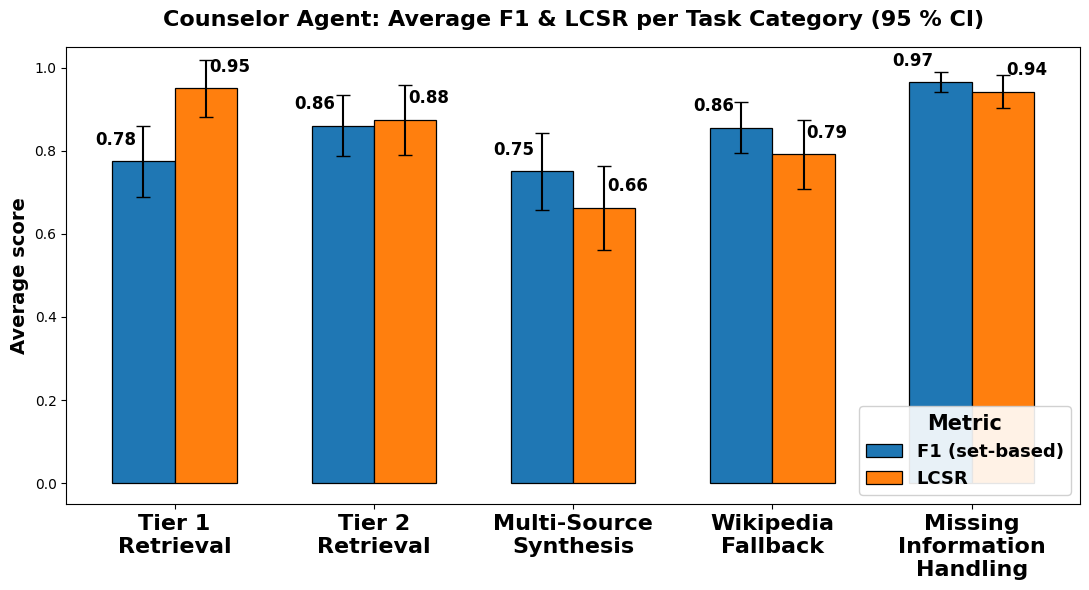

In [107]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, textwrap

# ── 1.  LOAD CSV & ENSURE LIST-COLUMNS ─────────────────────────────
df = pd.read_csv("education_agent_benchmark_results_enriched.csv")

def to_list(x):
    if isinstance(x, list): return x
    if pd.isna(x):          return []
    return eval(x) if isinstance(x, str) else []

df["tool_order_gold"]  = df["tool_order_gold"].apply(to_list)
df["tool_order_clean"] = df["tool_order_clean"].apply(to_list)

# ── 2.  ADD  F1 · LCSR  (EMA optional) ────────────────────────────
if not {"F1", "LCSR"}.issubset(df.columns):

    def lcs_len(a, b):
        n, m = len(a), len(b)
        dp = [[0]*(m+1) for _ in range(n+1)]
        for i in range(n):
            for j in range(m):
                dp[i+1][j+1] = dp[i][j]+1 if a[i]==b[j] else max(dp[i][j+1], dp[i+1][j])
        return dp[n][m]

    def row_metrics(row):
        G, P = row["tool_order_gold"], row["tool_order_clean"]
        gs, ps = set(G), set(P)
        prec   = len(gs & ps)/len(ps) if ps else 1.0
        rec    = len(gs & ps)/len(gs) if gs else 1.0
        f1     = 2*prec*rec/(prec+rec) if prec+rec else 0.0
        lcsr   = lcs_len(G, P)/len(G) if G else 1.0
        return pd.Series({"F1": f1, "LCSR": lcsr})

    df[["F1", "LCSR"]] = df.apply(row_metrics, axis=1)

# ── 3.  AGGREGATE  (mean ±95 % CI) ────────────────────────────────
plot_metrics = ["F1", "LCSR"]
cat_order = [
    "Tier 1 Retrieval", "Tier 2 Retrieval", "Multi-Source Synthesis",
    "Wikipedia Fallback", "Missing Information Handling",
]

agg = (df.dropna(subset=plot_metrics+["category"])
         .query("category in @cat_order")
         .groupby("category")[plot_metrics]
         .agg(["mean","std","count"]))

rows = []
for cat in agg.index:
    for m in plot_metrics:
        μ, σ, n = agg.loc[cat, (m,"mean")], agg.loc[cat,(m,"std")], agg.loc[cat,(m,"count")]
        ci      = 1.96*σ/np.sqrt(n) if n else 0
        rows.append({"category":cat, "metric":m, "mean":μ, "ci95":ci})
tidy = pd.DataFrame(rows)
tidy["category"] = pd.Categorical(tidy["category"], categories=cat_order, ordered=True)
tidy.sort_values("category", inplace=True)

# ── 4.  BAR PLOT  (values jittered left / right of error bar) ──────────────
colors    = ["#1f77b4", "#ff7f0e"]                # F1 , LCSR
label_map = {"F1": "F1 (set-based)", "LCSR": "LCSR"}
cats      = cat_order
bar_w     = 0.25
x_pos     = np.arange(len(cats))*0.8              # tighter clusters

fig, ax = plt.subplots(figsize=(11, 6))

for i, (metric, color) in enumerate(zip(["F1", "LCSR"], colors)):
    sub   = tidy[tidy.metric == metric]
    means = sub["mean"].values
    errs  = sub["ci95"].values
    xpos  = x_pos + i*bar_w

    bars = ax.bar(
        xpos, means, width=bar_w,
        yerr=errs, capsize=5,
        color=color, edgecolor="black", linewidth=0.9,
        label=label_map[metric]
    )

    # ── add value labels with horizontal jitter ──────────────────────────
    jitter = (-0.45 if metric == "F1" else 0.38) * bar_w  # left for F1, right for LCSR
    for bar, val in zip(bars, means):
        ax.text(
            bar.get_x() + bar.get_width()/2 + jitter,
            bar.get_height() + 0.03,          # a bit above the top
            f"{val:.2f}",
            ha="center", va="bottom",
            fontsize=12, fontweight="bold"
        )

# ── axis / legend formatting (unchanged) ───────────────────────────────────
wrapped = [textwrap.fill(c, 14) for c in cats]
ax.set_xticks(x_pos + bar_w/2)
ax.set_xticklabels(wrapped, fontweight="bold", fontsize=16)

ax.set_ylabel("Average score", fontsize=14, fontweight="bold")
ax.set_title("Counselor Agent: Average F1 & LCSR per Task Category (95 % CI)",
             fontsize=16, fontweight="bold", pad=15)

ax.set_ylim(-0.05, 1.05)
ax.set_yticks(np.linspace(0, 1, 6))

leg = ax.legend(title="Metric", loc="lower right",
                frameon=True, framealpha=0.9,
                fontsize=13, title_fontsize=15)
leg.get_title().set_fontweight("bold")
for t in leg.get_texts():
    t.set_fontweight("bold")

fig.tight_layout()
plt.show()